# Introduction

This notebook is used to explore results in general, performing quick DE results or looking at expression of certain genes in UMAP space.

# Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import sparse
import warnings
import itertools as it
import json
import seaborn as sns
import pickle as pkl
from functools import reduce
import gc
import timeit

from nero import Nero as nr

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=16

In [3]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

## Load in Data

In [9]:
path = prefix_comb + 'h5ads/concat_6.h5ad'
# concat.write_h5ad(path)
concat = sc.read_h5ad(path)

In [5]:
concat.obsm['X_umap']

array([[ -3.6252222,   9.230064 ],
       [ -1.3476787,   6.3715477],
       [ -5.551411 , -11.817153 ],
       ...,
       [ -1.4935483,   2.255933 ],
       [  5.350238 , -11.410318 ],
       [  2.157029 , -11.410807 ]], dtype=float32)

In [6]:
concat = concat[concat.obs['cond'] != '0'].copy()

In [7]:
with open(mountpoint + 'meta.pkl', 'rb') as file:
    ct_colors = pkl.load(file)['ct_colors']['ct2']['hex']
with open(mountpoint + 'meta.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['cond_colors']['hex']

## Functions

In [8]:
def specificity_plot(adata, feature, thresh=None, ct_type='ct2', 
                     cts=None, conds=None, bins=50, logy=True, fontsize=12,
                     from_zero=False
                    ):
    '''
    Create a figure with 2 histograms and a scatter plot showing the distribution 
    of expression levels over all cells in adata, restricting to `cts` and `conds`.
    The first histogram shows the distribution across all cells, the second shows
    the same distribution broken up by `cond`. The scatter plot shows the 
    percentage of and mean expression of cells above `thresh`. This can be used to
    filter cells with expression = 0. 
    
    '''
    vals = adata.obs_vector(feature)
    obs = adata.obs.copy()
    f_name = feature + '_violin'
    obs[f_name] = vals
    
    if isinstance(cts, type(None)):
        cts = np.unique(obs[ct_type])
    else:
        obs = obs[obs[ct_type].isin(cts)].copy()
    if isinstance(conds, type(None)):
        conds = np.unique(obs['cond'])
    else:
        obs = obs[obs['cond'].isin(conds)].copy()
    
    vals = obs[f_name].values
    if isinstance(thresh, type(None)):
        thresh = vals.min()
        
    thresh_str = '{:03.2f}'.format(thresh)
    
    fig = plt.figure(figsize=(10, 5))
    gs = plt.GridSpec(2, 2, figure=fig)
    hist1 = fig.add_subplot(gs[0, 0])
    hist2 = fig.add_subplot(gs[1, 0], sharex=hist1, sharey=hist1)
    scatter_ax = fig.add_subplot(gs[:, 1])
    
    hist1.hist(vals, bins=bins)
    if logy:
        hist1.set_yscale('log');
    scatter_data = list()
    for cond in conds:
        sub_vals = obs[obs['cond'] == cond][f_name].values
        hist2.hist(sub_vals, bins=bins, color=cond_colors[cond], alpha=0.5)
        if logy:
            hist2.set_yscale('log')
        
        pos_bool = (sub_vals >= thresh)
        num_pos = pos_bool.sum()
        tot_num = sub_vals.shape[0]
        if num_pos > 0:
            scatter_data.append((num_pos/tot_num, 
                                 sub_vals[pos_bool].mean(),
                                 cond_colors[cond]))
    if thresh != 0:
        hist1.vlines(thresh, *hist1.get_ylim(), color='k', linestyle='--')
        hist2.vlines(thresh, *hist2.get_ylim(), color='k', linestyle='--')
    scatter_df = pd.DataFrame(scatter_data, columns=['x', 'y', 'c'])
    scatter_ax.scatter(x=scatter_df['x'].values, y=scatter_df['y'].values, c=scatter_df['c'].values)
    
    if isinstance(from_zero, bool):
        scatter_ax.set_ylim((0, scatter_ax.get_ylim()[1]*1.1))
        scatter_ax.set_xlim((0, scatter_ax.get_xlim()[1]*1.1))
    elif from_zero == 'x':
        scatter_ax.set_xlim((0, scatter_ax.get_xlim()[1]*1.1))
    elif from_zero == 'y':
        scatter_ax.set_ylim((0, scatter_ax.get_ylim()[1]*1.1))
    
    hist1.set_title('Expression distribution', fontsize=fontsize)
    hist2.set_title('Expression distribution, by cond', fontsize=fontsize)
    scatter_ax.set_title('Percent by mean expression >= %s' % thresh_str, fontsize=fontsize)

    hist1.set_ylabel('Number of cells', fontsize=fontsize)
    hist2.set_ylabel('Number of cells', fontsize=fontsize)
    scatter_ax.set_ylabel('Mean expression of cells with %s >= %s' % (feature, thresh_str), fontsize=fontsize)

    hist1.set_xlabel('Expression of %s' % feature, fontsize=fontsize)
    hist2.set_xlabel('Expression of %s' % feature, fontsize=fontsize) 
    scatter_ax.set_xlabel('Percent of cells with %s >= %s' % (feature, thresh_str), fontsize=fontsize)
    plt.tight_layout()
    return

# Explore

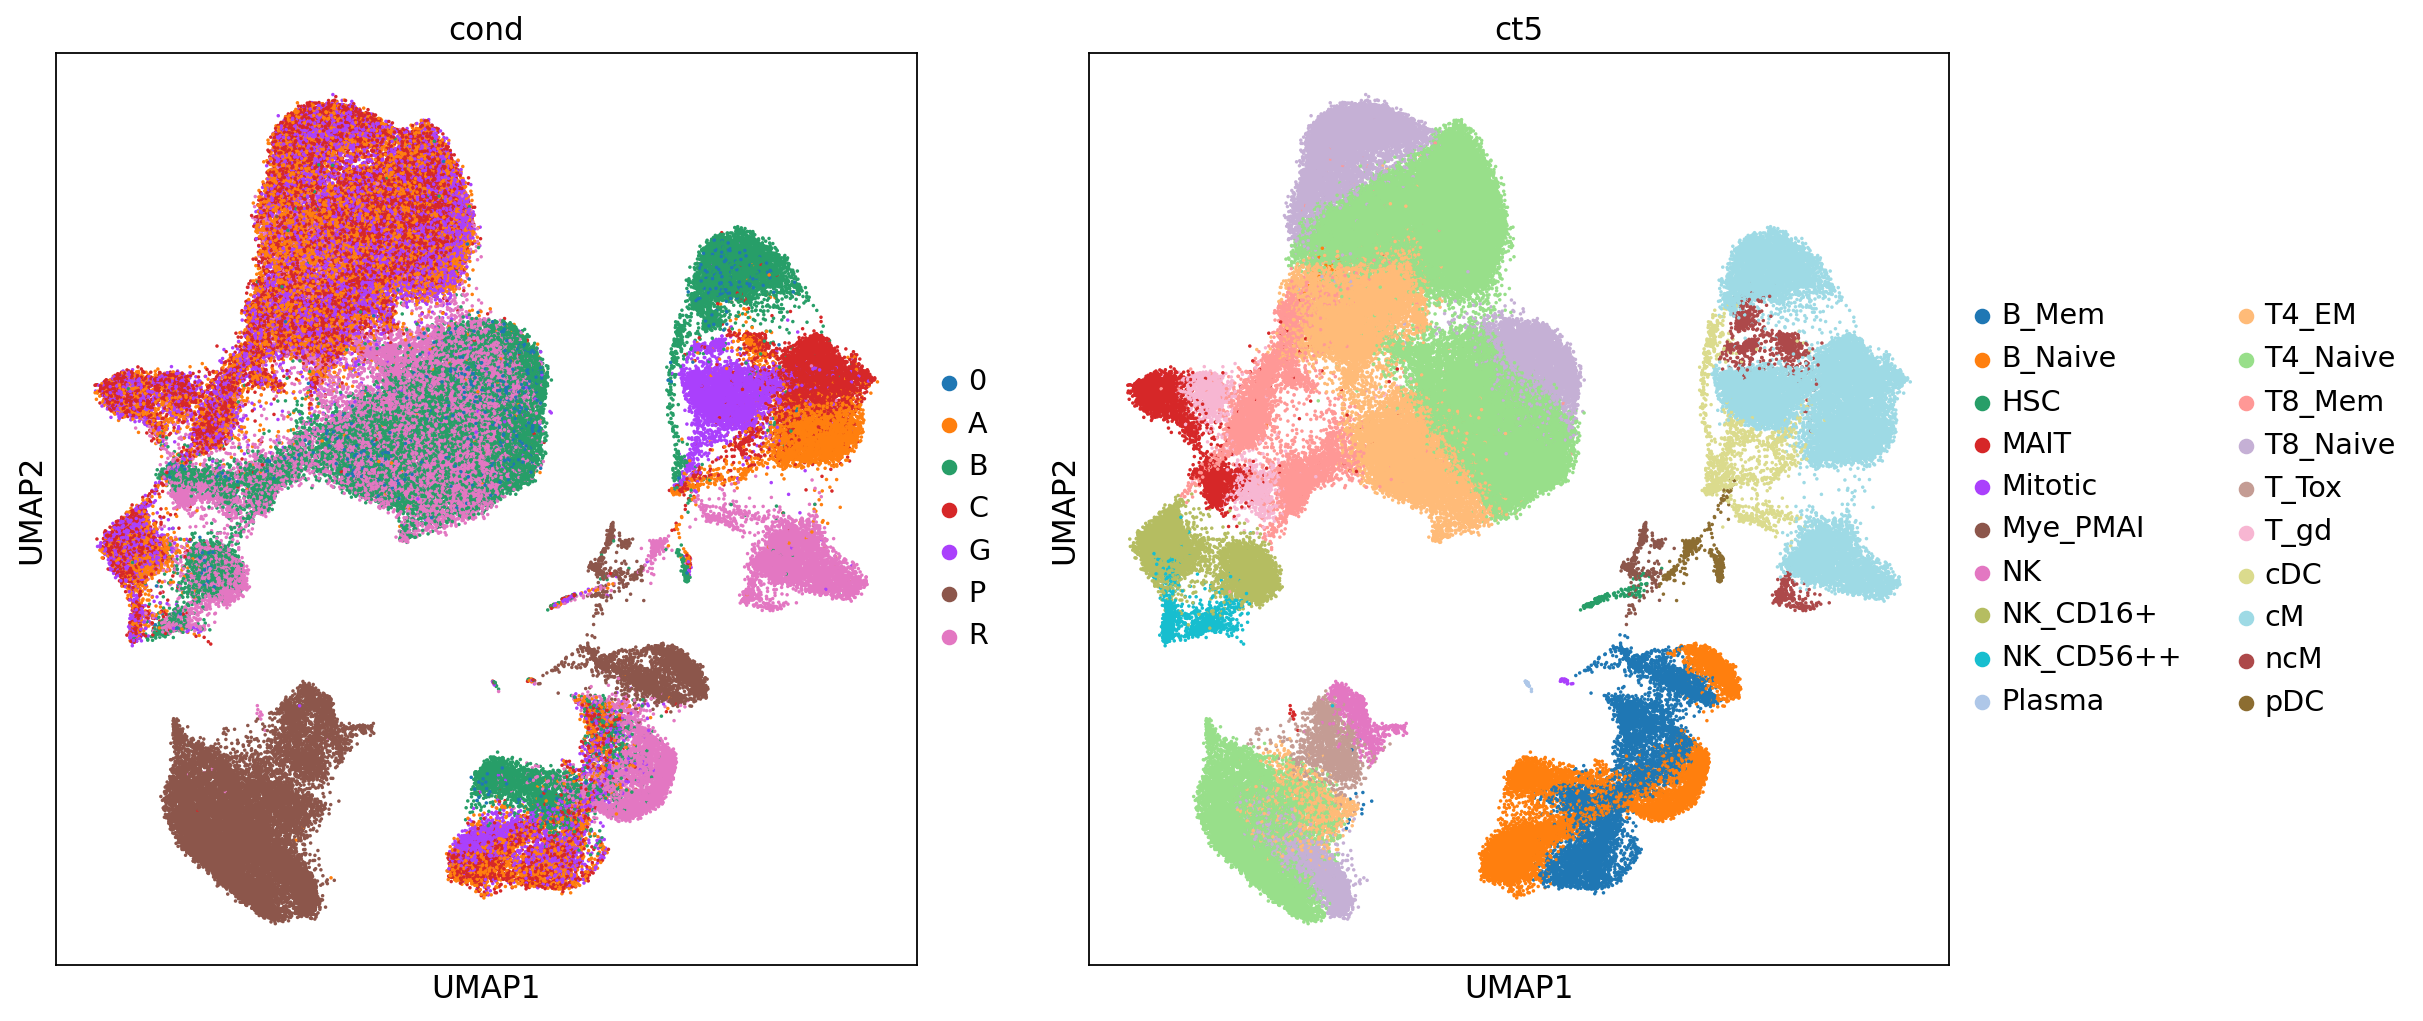

In [19]:
# sc.pl.umap(concat, color=['cond', 'ct2'])
# sc.pl.umap(concat, color=['ct4'])
# sc.pl.umap(concat, color=['ct3'])
nr.plot_features(concat, bg='white', features=['cond', 'ct5'], figsize_scale=2, size=10);

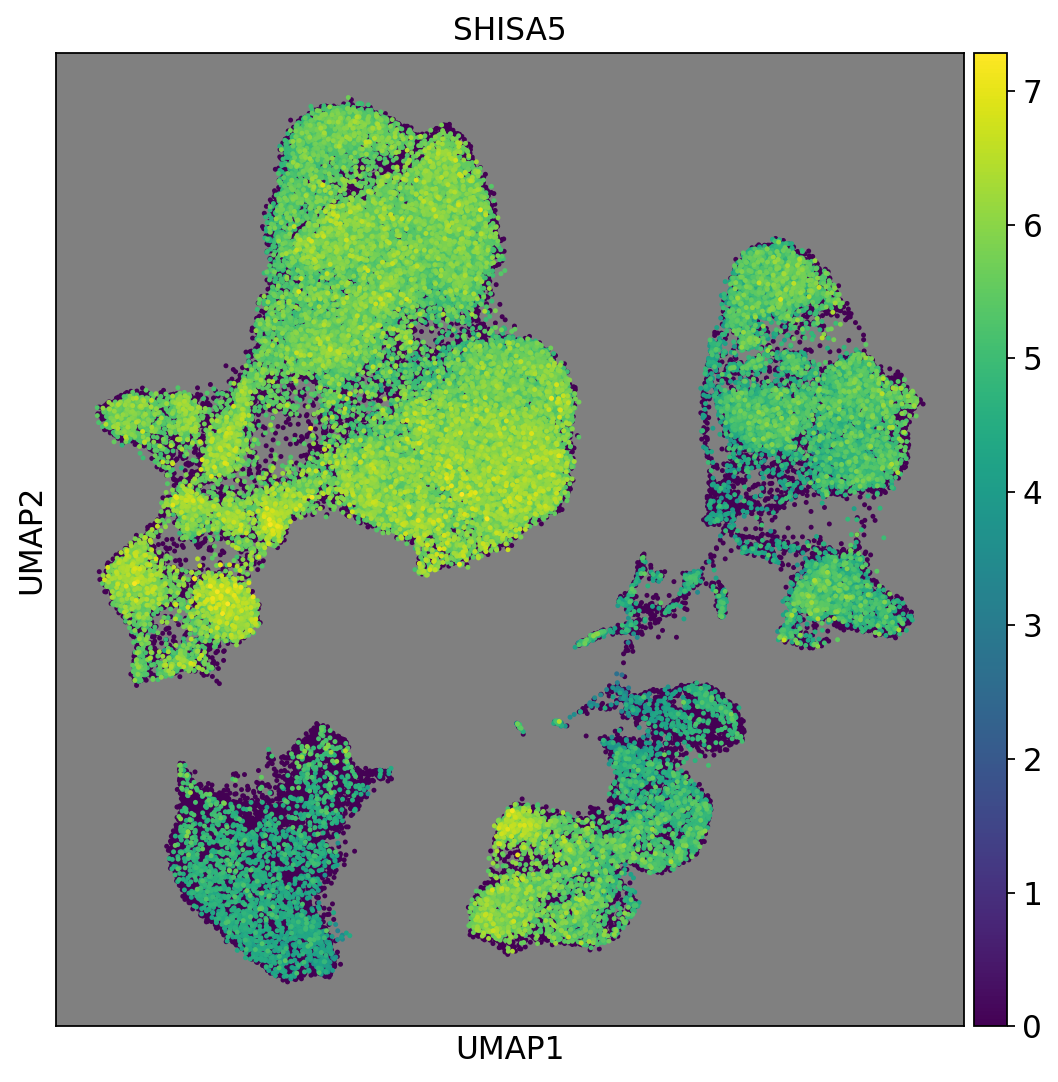

In [23]:
feature = 'SHISA5'
nr.highlight_feature(concat, feature);

In [41]:
cM = concat[((concat.obs['ct2'] == 'cM') & (concat.obs['cond'].isin(['C', 'B', 'G'])))].copy()

In [37]:
def replace_none(provided_dict, default_dict):
    if isinstance(provided_dict, type(None)):
        provided_dict = default_dict
    else:
        for k in provided_dict:
            default_dict[k] = provided_dict[k]
        provided_dict = default_dict
    return provided_dict
def excise_umap(adata, pick=False, cbs=None, 
                pick_params = None,
                cbs_params = None):
    '''
    Extract the xlim and ylim of an adata's UMAP that would
    zoom in on a particular area of the UMAP. You can specify: 
    
    (1) specific cell barcodes (`cbs`), with optional pad/crop 
        (`buffer`) and `offsets`.
        
    (2) a particular area by setting `pick`=True. This will display
        a UMAP with gridlines, after which you input an x, y, and 
        radius (r). The returned xlim and ylim will be x +/- r, 
        y +/- r. You may suppress the UMAP plot by directly providing
        x, y, and r in `pick_params`. 
        
    
    `adata`: annotated data matrix
    `pick`: boolean, if you would like to "pick" the spot on UMAP
    `cbs`: a list of cell barcodes to zoom in on, ignored if 
           `pick==True`
    `pick_params`: dict, may include 'pick_num' (number of ticks on
                   resulting UMAP, default=20) and `xyr`, directly 
                   provided values of x, y locations and radius using 
                   `pick_num` intervals (default=None, prompted)
    `cbs_params`: dict, may include `buffer` (float as a percentage of
                  full UMAP space) that pads (positive) or crops 
                  (negative) frame by constant amount on all sides; 
                  and `offsets`, 2-tuple of offset frame by a percentage 
                  of full umap space; offsets can be positive (shift 
                  frame up/right) or negative (down/left)
    
    returns: umap_xlim, umap_ylim; the range of xlim and ylim 
             that centers view of UMAP space on the provided 
             cells
    '''
    default_pick_params = {'pick_num': 20, 'xyr': None}
    default_cbs_params = {'buffer': 0.0, 'offsets': (0.0, 0.0)}
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax = sc.pl.umap(concat, ax=ax, show=False, return_fig=False)
    (full_umap_xmin, full_umap_xmax), (full_umap_ymin, full_umap_ymax) = ax.get_xlim(), ax.get_ylim()
    full_umap_xrange, full_umap_yrange = full_umap_xmax - full_umap_xmin, full_umap_ymax - full_umap_ymin
    if pick:
        pick_params = replace_none(pick_params, default_pick_params)
        pick_num = pick_params['pick_num']
        xtix = np.linspace(full_umap_xmin, full_umap_xmax, num=pick_num + 1, endpoint=True)
        ytix = np.linspace(full_umap_ymin, full_umap_ymax, num=pick_num + 1, endpoint=True)
        unit_x, unit_y = xtix[1] - xtix[0], ytix[1] - ytix[0]
        if isinstance(pick_params['xyr'], type(None)):
            ax.set_xticks(xtix)
            ax.set_xticklabels(range(pick_num + 1))
            ax.set_yticks(ytix)
            ax.set_yticklabels(range(pick_num + 1))
            ax.grid(zorder=3)
            plt.show()
            ans = input('x, y, r: ')
            X, Y, radius = tuple(map(lambda x: float(x.strip()), ans.split(',')))
        else:
            plt.close()
            X, Y, radius = pick_params['xyr']
        new_xlim = (unit_x*(X - radius)+full_umap_xmin, unit_x*(X + radius)+full_umap_xmin)
        new_ylim = (unit_y*(Y - radius)+full_umap_ymin, unit_y*(Y + radius)+full_umap_ymin)
    else:
        plt.close()
        assert not isinstance(cbs, type(None)), "Must choose `pick=True`, or provide `cbs`."
        cbs_params = replace_none(cbs_params, default_cbs_params)
        buffer = cbs_params['buffer']
        offsets = cbs_params['offsets']
    
        # get the full scale umap xlim and ylim


        # get the specific X and Y values, and mins/maxes, of the cells
        X, Y = concat[cbs, :].obsm['X_umap'].T.toarray()
        xmax, xmin, ymax, ymin = X.max(), X.min(), Y.max(), Y.min()

        # define the lims, ranges, and midpoints of the x and y data
        data_xlim, data_ylim = np.array([xmin, xmax]), np.array([ymin, ymax])
        data_xrange, data_yrange = xmax - xmin, ymax - ymin
        data_xmid, data_ymid = data_xlim.mean(), data_ylim.mean()

        # adjust frame to a square b/c UMAPs are squares, use the range of the axis that's bigger
        # need to scale by the full umap lims, otherwise clusters look skewed/stretched
        max_percent_of_full = max([data_xrange/full_umap_xrange, data_yrange/full_umap_yrange])
        new_xrange, new_yrange = full_umap_xrange*max_percent_of_full, full_umap_yrange*max_percent_of_full

        # prepare the buffer and offsets
        offx, offy = -offsets[0]*full_umap_xrange, -offsets[1]*full_umap_yrange
        buffx, buffy = buffer*full_umap_xrange, buffer*full_umap_yrange

        # compute the new xlim and ylim
        new_xlim = (data_xmid - new_xrange/2 + offx - buffx, data_xmid + new_xrange/2 + offx + buffx) 
        new_ylim = (data_ymid - new_yrange/2 + offy - buffy, data_ymid + new_yrange/2 + offy + buffy)
    
    return new_xlim, new_ylim

In [42]:
xlim, ylim = excise_umap(concat, pick=True, pick_params={'xyr': (16.65, 13.6, 3)})

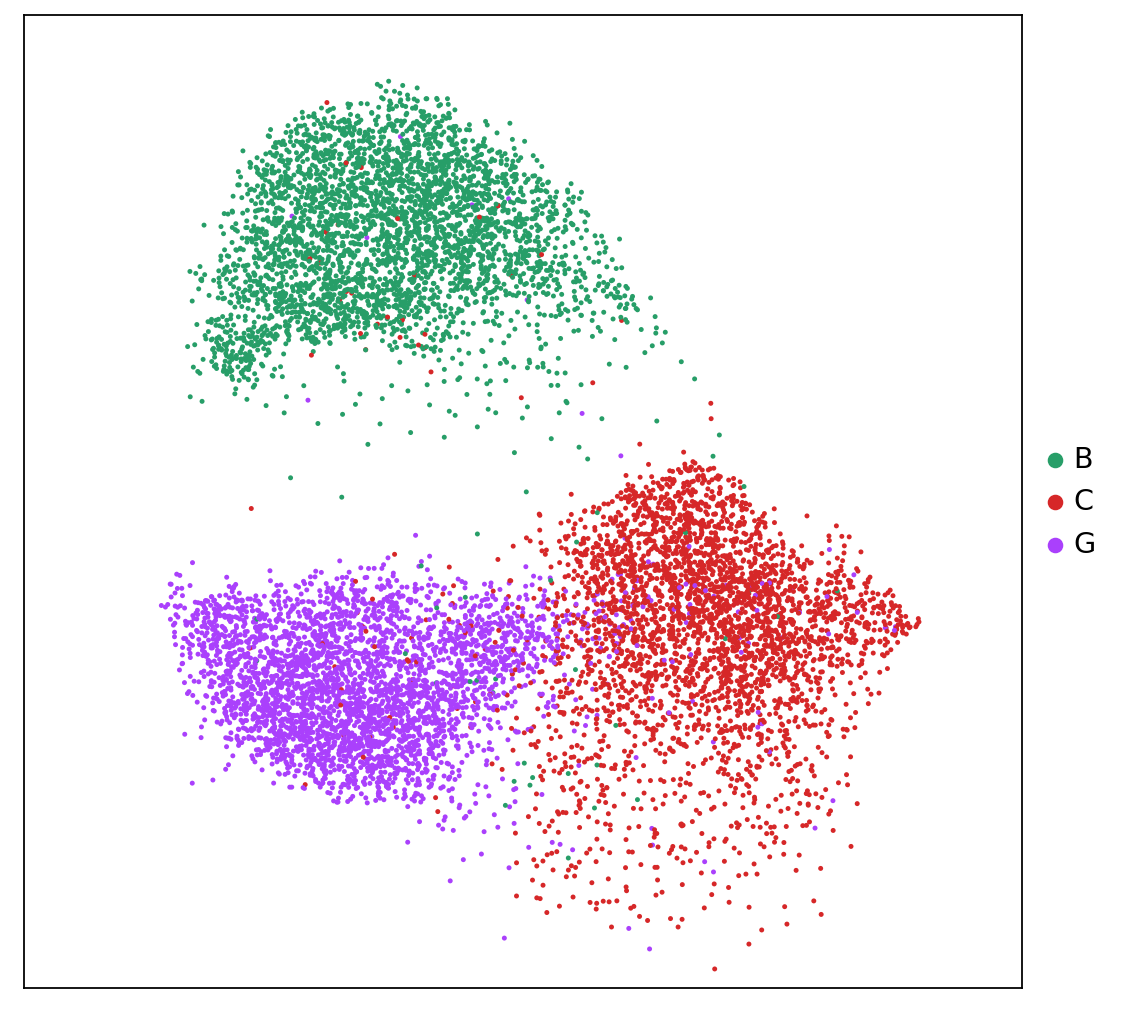

In [43]:
# targets = [target] if target in counts.var_names else gene
target = 'cond'

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax = sc.pl.umap(cM, color=target, ax=ax, show=False, 
                use_raw=False, return_fig=False, size=20, title='',
                sort_order=True
                )
# ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xlim(xlim)
ax.set_ylim(ylim);

In [15]:
sc.tl.rank_genes_groups(cM, groupby='cond', groups=['G'], reference='C')
dge = nr.get_dge(cM)

ranking genes
    consider 'cond' groups:
    with sizes: [3512 3345]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/ssm-user/miniconda3/envs/clue/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:237: RuntimeWarning: overflow encountered in expm1
  foldchanges = (expm1_func(mean_group) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's
/home/ssm-user/miniconda3/envs/clue/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:237: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (expm1_func(mean_group) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's


In [30]:
dge[dge['pvals_adj'] < 0.05].sort_values(by='logfoldchanges', ascending=False).head(20).tail(10)

scores     names  logfoldchanges  pvals  pvals_adj group
2   85.429855      IDO1       45.784592    0.0        0.0     G
6   79.335724      CD74       43.600338    0.0        0.0     G
9   76.776123  HLA-DPB1       41.203106    0.0        0.0     G
23  65.528107     HLA-C       38.519608    0.0        0.0     G
40  58.779739     HLA-A       37.252232    0.0        0.0     G
86  43.137516     CXCL9       31.657661    0.0        0.0     G
3   84.665451      GBP5       27.646994    0.0        0.0     G
66  47.746536      SAT1       26.875750    0.0        0.0     G
41  58.705704      CTSS       26.693766    0.0        0.0     G
0   87.561371     PSME2       26.323767    0.0        0.0     G

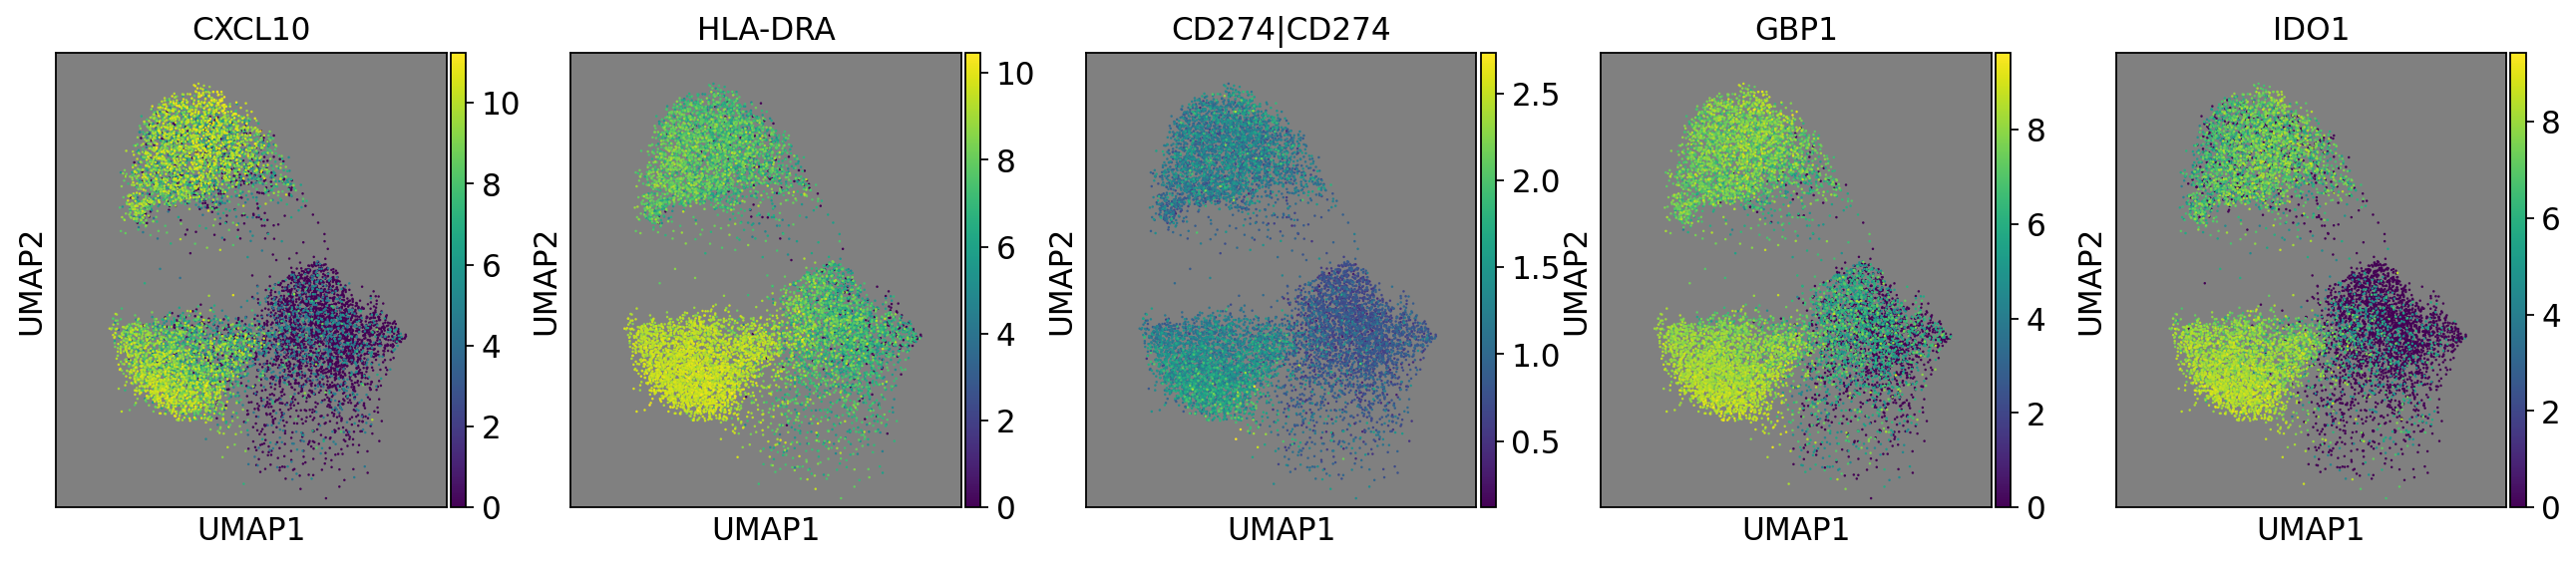

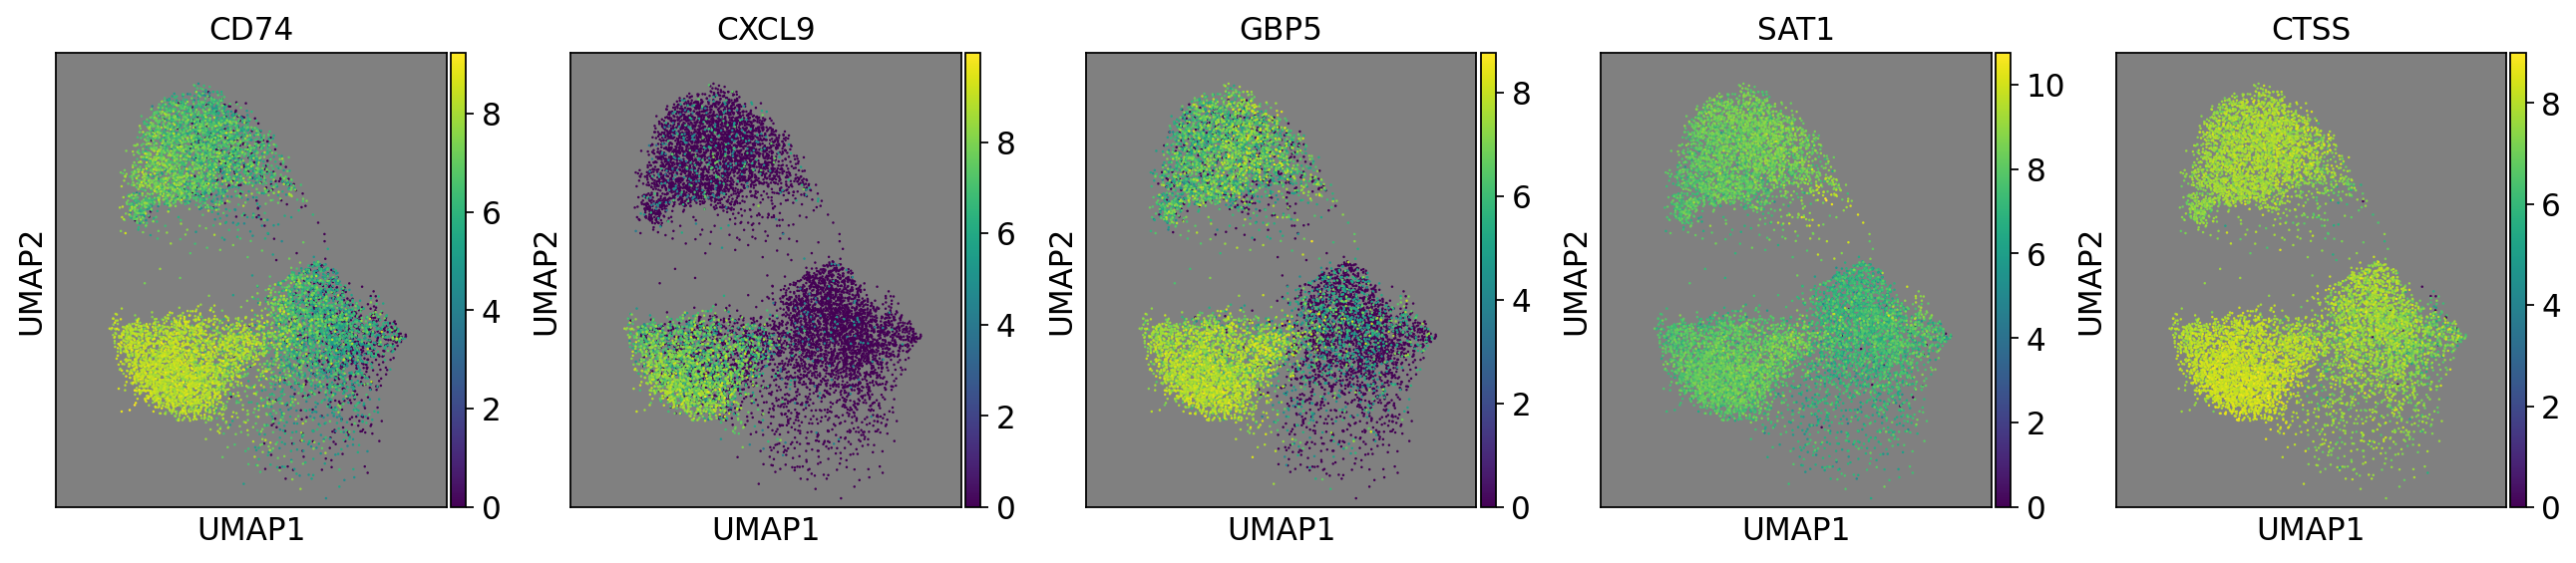

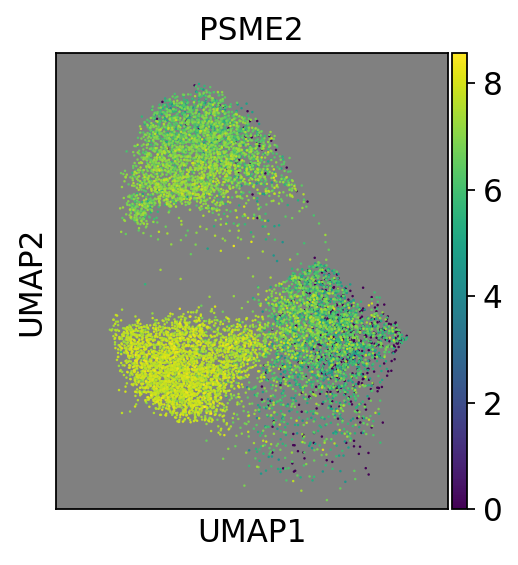

In [53]:
figaxes = nr.plot_features(cM, features=['CXCL10', 'HLA-DRA', 'CD274|CD274', 'GBP1', 'IDO1', 'CD74', 'CXCL9', 'GBP5', 'SAT1', 'CTSS', 'PSME2'], 
                           use_raw=False, show=False);
for (fig, axes) in figaxes:
    for ax in axes:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

IndexError: list index out of range

In [14]:
concat_T = concat[concat.obs['ct4'].isin(['T4', 'T8_Naive'])].copy()

In [15]:
concat_T.obs['ct3'].unique().tolist()

['T8_RA+_SELLint',
 'T4_RA+_SELL+',
 'T4_Naive',
 'T8_RA+_SELL+',
 'T4_CM',
 'T4_Treg_Act_GPCR',
 'T4_Treg_Resting',
 'T4_RA+_SELLint',
 'T4_Act',
 'T4_T8_RA+_SELLint_R848',
 'T4_RO+_SELL+',
 'T8_RO+_CD103+',
 'T4_Treg_Act',
 'T4_RO+_Act',
 'T4_RA+_Act_stress',
 'T8_Naive',
 'T4_T8_Act2_R848',
 'T4_T8_RO+_SELL-',
 'T4_RO+_IL4R+',
 'T4_EM',
 'T4_T8_Act1_R848',
 'Th2',
 'T_gd',
 'T8_CM',
 'MAIT',
 'T8_TEMRA',
 'T_CD10+',
 'T8_HOBIT+HELIOS+',
 'T8_EM']

In [16]:
# def highlight_clust(adata, key, clusts, bg='lightgray', bg_cells='gray', figsize=(8,8), other_label='other'):
#     '''
#     Highlight cluster(s) in UMAP space with background color.
    
#     `adata`: annotated data matrix
#     `key`: name of column in `adata.obs` with the clusters
#     `clusts`: member(s) of `adata.obs[key]` to highlight
#     `bg`: background color, accepted by matplotlib.ax.set_facecolor()
#     `bg_cells`: color of non-highlighted cells
#     `figsize`: size of resulting figure
#     `other_label`: key added to adata.obs used internally, but can be provided
#                    with str if default 'other' is already in use in adata.obs
    
#     returns: `ax`, matplotlib Axes object
#     '''
    
#     if isinstance(clusts, str):
#         label = key + ':' + clusts
#         clusts = [clusts]
#     elif isinstance(clusts, list):
#         clusts_len = len(clusts)
#         if clusts_len <= 3:
#             label = key + ':' + '&'.join(clusts)
#         else:
#             label = key + ':' + str(clusts_len) + '_clusts'
        
#     other_clusts = np.setdiff1d(np.unique(adata.obs[key]), clusts)
#     adata.obs[label] = adata.obs[key].copy()
#     adata.obs[label].replace(dict(it.product(other_clusts, [other_label])), inplace=True)
#     adata.obs[label] = adata.obs[label].astype('category')
#     adata.obs[label].cat.reorder_categories(new_categories=[other_label] + clusts, ordered=True, inplace=True)
    
#     key_cdict = dict(zip(adata.obs[key].cat.categories, adata.uns[key + '_colors']))
#     label_cdict = dict()
#     for clust in adata.obs[label].cat.categories:
#         if clust == other_label:
#             label_cdict[clust] = bg_cells
#         else:
#             label_cdict[clust] = key_cdict[clust]
    
#     adata.uns[label + '_colors'] = list(label_cdict.values())
    
#     fig, ax = plt.subplots(1, 1, figsize=figsize)
#     ax.set_facecolor(bg)
#     sc.pl.umap(adata, color=label, ax=ax, return_fig=False, show=False, size=20, sort_order=True)
#     adata.obs.drop(columns=[label], inplace=True)
#     return ax

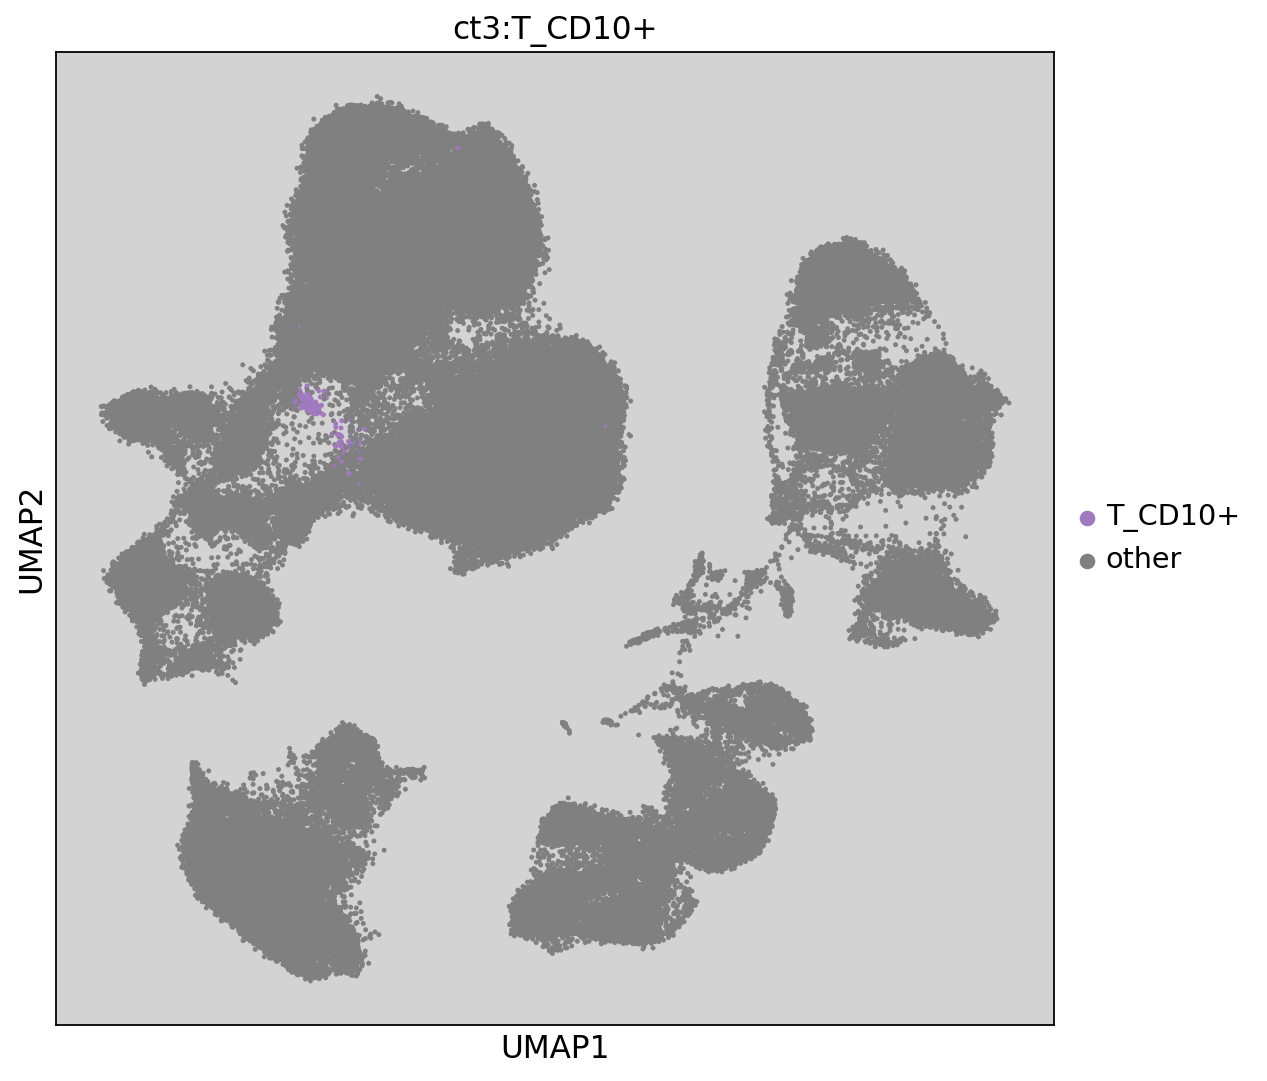

In [19]:
nr. highlight_clust(concat, 'ct3', 'T_CD10+');

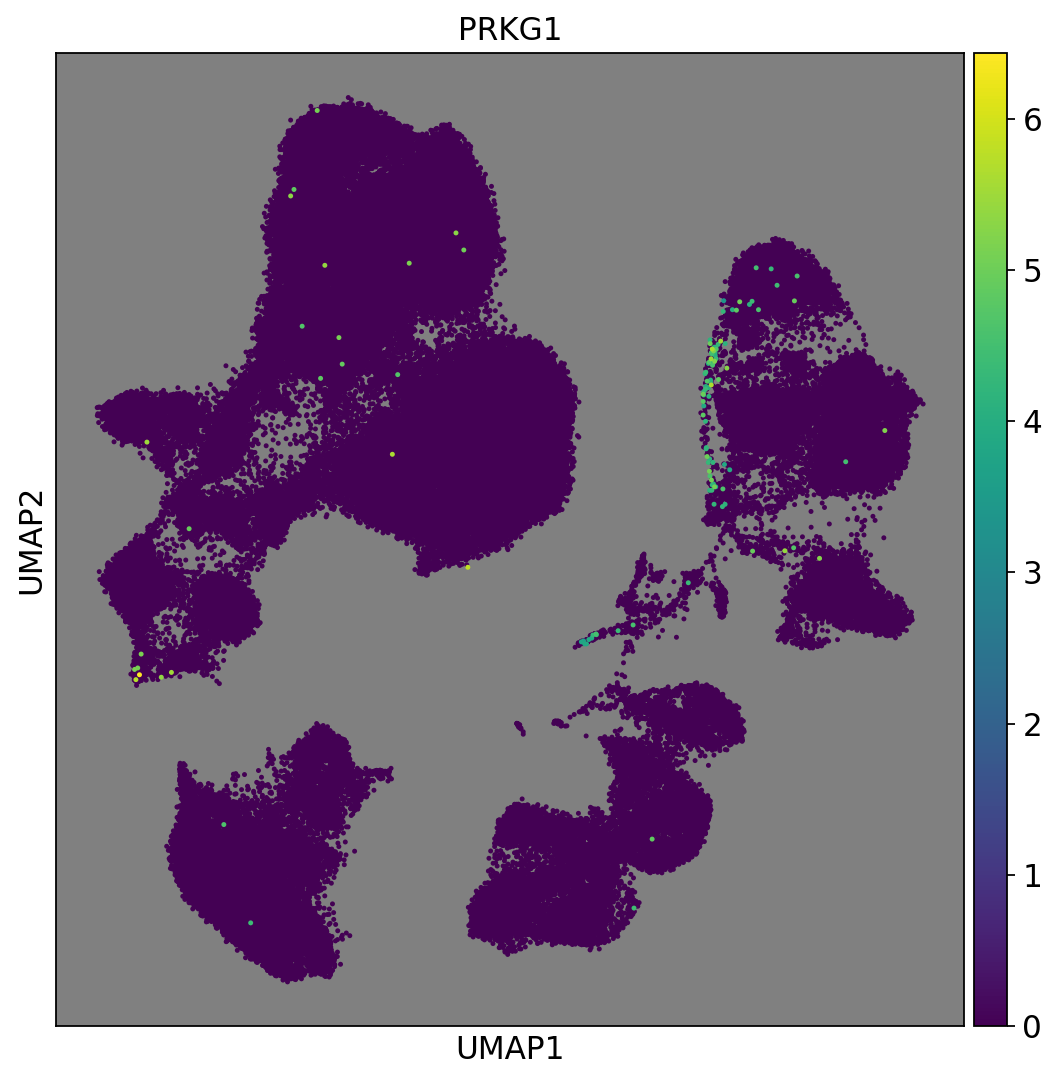

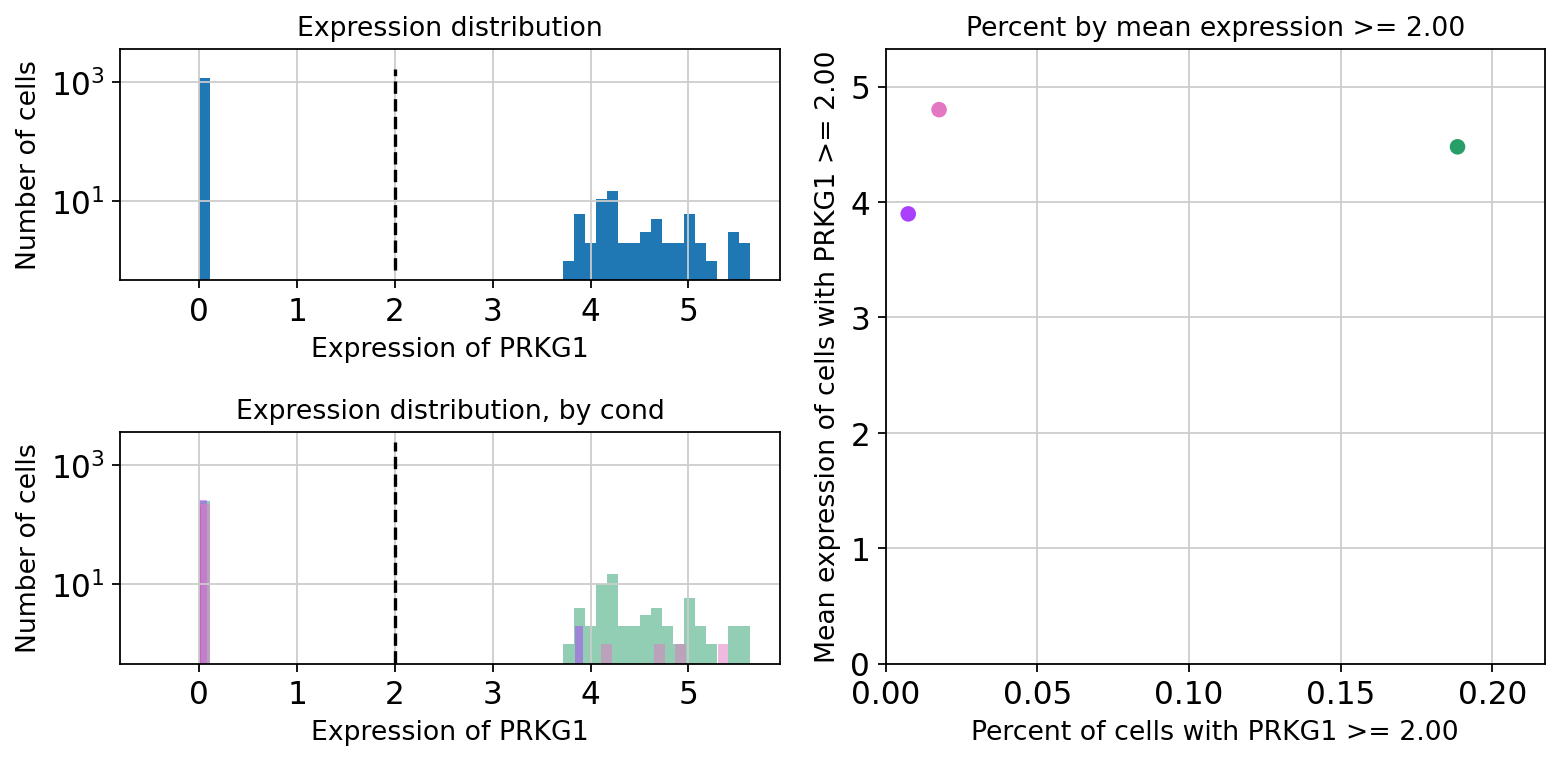

In [20]:
feature = 'PRKG1'
nr.highlight_feature(concat, feature);
specificity_plot(concat, feature, thresh=2, ct_type='ct2', cts=['cDC'], logy=True)

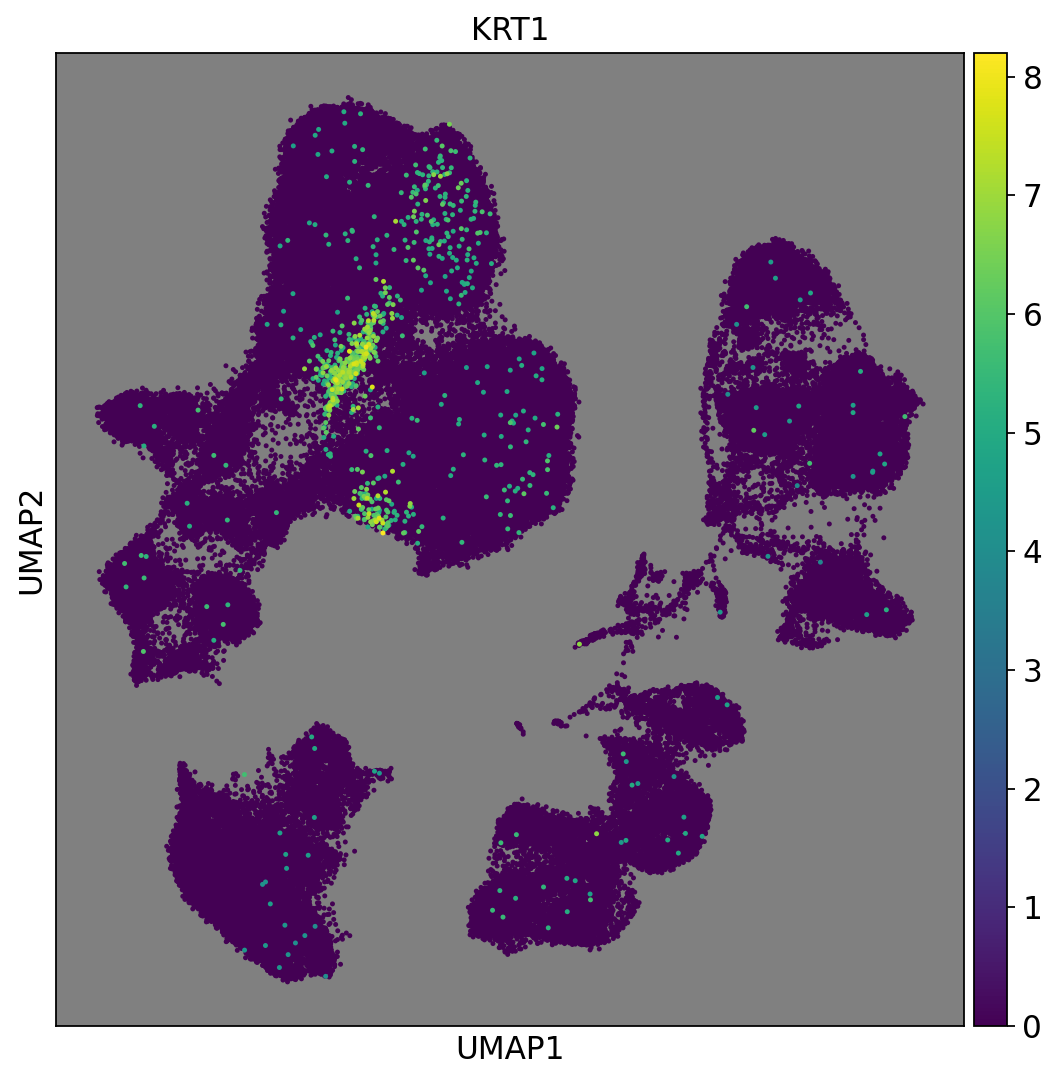

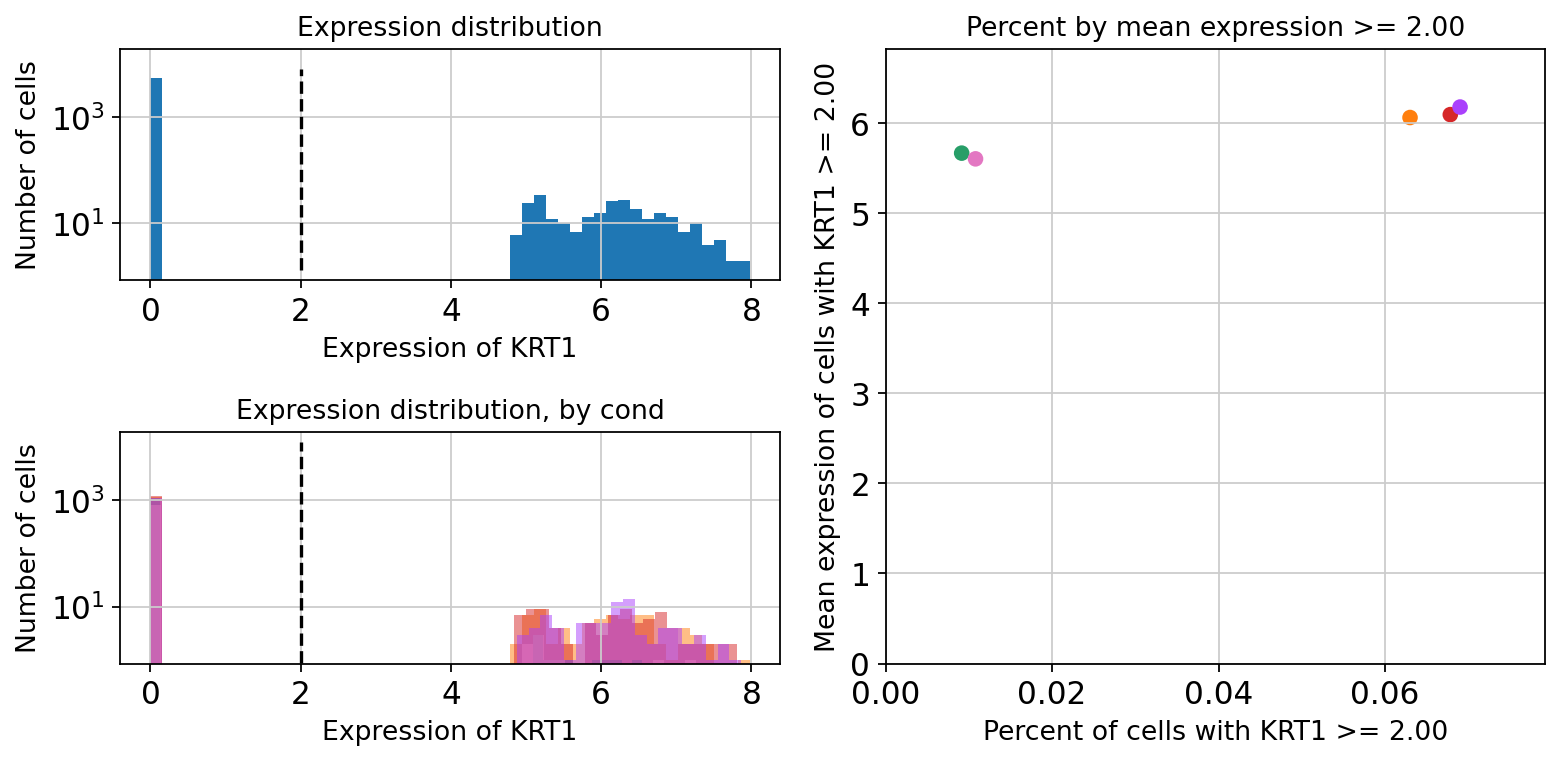

In [24]:
feature = 'KRT1'
nr.highlight_feature(concat, feature);
specificity_plot(concat, feature, thresh=2, ct_type='ct3', cts=['T4_RO+_SELL+'], logy=True)

In [122]:
concat.obs['ct2-cond'] = (concat.obs['ct2'].astype(str) + '-' + concat.obs['cond'].astype(str)).astype('category')

In [137]:
concat_mye = concat[concat.obs['ct4'] == 'Myeloid'].copy()

In [138]:
key = 'ct2-cond'
g1 = ['cDC-G']
g2 = [i for i in concat_mye.obs[key].cat.categories if i not in g1]
nr.add_lowde(concat_mye, key=key, groups=[g1, g2])

In [139]:
nr.low_de_compare(concat_mye, compare=(g1, g2), p=0.1, p_of=g1[0])

OR2I1P      26.058285
UBD         13.729796
PDGFRA       7.395189
CLEC10A      6.761702
IDO2         6.724444
              ...    
CXCL3        0.322129
RASGEF1B     0.310445
GAPT         0.294756
LHFPL2       0.269419
MAFB         0.255887
Length: 7619, dtype: float64

In [142]:
feature = 'CLEC10A'

nr.highlight_feature(concat, feature);
specificity_plot(concat, feature, thresh=2, ct_type='ct2', cts=['cDC'], logy=True)